In [ ]:
"""
Refine sentiment analysis

Polairty throughout the speech
    - focus on VADER and smooth the line plot
    - check polarity by categories (speaker profession)
    - saved four figures for slides (Entertainment, Tech/Business, Med/Law, Academia(Education/Research))

"""

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

## 1. Load data

In [2]:
# Basic speech_df
speech_df = pd.read_pickle('../dump/speech_clean_lemma')
speech_df_raw = pd.read_pickle('../dump/speech_df')

# Speech + speaker and school info
speech_speaker_cat = pd.read_pickle('../dump/speech_speaker_cat')
speech_speaker_cat = speech_speaker_cat.sort_values(by=['speaker','year']).reset_index(drop=True)
speech_speaker_region = pd.read_pickle('../dump/speech_speaker_region')
speech_speaker_region = speech_speaker_region.sort_values(by=['speaker','year']).reset_index(drop=True)

In [3]:
# Keep the essentials and merge

columns_keep_1 = ['speaker','year','school','transcript','transcript_clean','category','age','age_then','age_cat',]
columns_keep_2 = ['speaker','year','region']

speech_concise = pd.merge(speech_speaker_cat[columns_keep_1],speech_speaker_region[columns_keep_2],\
                         on=['speaker','year'],how='left')

In [4]:
# # Pickle
# speech_concise.to_pickle('../dump/speech_concise')

## 2. VADER

### Instantiate analyzer and prepare functions for plots

In [5]:
# Instantiate the analyzer
analyzer = SIA()

#### Analyze sentiment based on parts (sections).

In [6]:
# Split each speech into 10 parts

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [7]:
def polarity_speech(transcript):
    """
    Input: one transcript (with original punctuation)
    Output: polarity plot throughout the speech
    
    Divide the transript to 10 sections
    
    """
#     sents = transcript.split(".")
    
    sents = split_text(transcript, n=10)

    results = []
    for sent in sents:
        ana = analyzer.polarity_scores(sent)
        results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])

    vader_sent_df = pd.DataFrame(results,columns=['neg','neu','pos','compound'])
    
    return simple_plot('compound',vader_sent_df,\
                'Polarity','',\
                title = '')

In [8]:
def polarity_plot(vader_sent_melt):
    # sns lineplot
#     plt.rcParams['figure.figsize'] = [12, 8]
    sns.lineplot(data=vader_sent_melt, x="variable", y="value")
    plt.title('',fontsize=20)
    plt.ylabel('Average polarity',fontsize=20)
    plt.xlabel('Section of speech',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14)
    
    sns.set_style("white")
    plt.ylim(-.8, 1)
    plt.yticks([-0.8, 0 ,1], labels = ['-0.', '0.0' ,'1.0'], fontsize=14)
    ;

In [9]:
# Try splitting to more sections
def polarity_all(df,num_split):
    # Split and analyze all transcripts
    all_transcripts = []

    for i in range(df.shape[0]):
        transcript = df.transcript.iloc[i]
        sents = split_text(transcript, n=num_split)
        results = []
        for sent in sents:
            ana = analyzer.polarity_scores(sent)
        #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
            results.append(ana['compound'])
        all_transcripts.append(results)

    # Create df
    vader_sent_df = pd.DataFrame(all_transcripts,
                                 columns=[str(i+1) for i in range(num_split)]                            )
    vader_sent_df['Transcript'] = [i for i in range(df.shape[0])]

    # Melt df (for sns lineplot 95% confidence interval)
    vader_sent_melt = pd.melt(vader_sent_df, id_vars='Transcript', value_vars = [str(i+1) for i in range(num_split)],
    #                          val_name = [str(i+1) for i in range(10)]
                             )

#     # sns lineplot
    plt.rcParams['figure.figsize'] = [12, 8]
#     fig,ax = plt.subplots(figsize=(12, 8))
#     sns.lineplot(data=vader_sent_melt, x="variable", y="value")
#     ax.set_title('Average polarity of all speeches over the duration',fontsize=20)
#     ax.set_ylabel('Average polarity',fontsize=20)
#     ax.set_xlabel('Throughout the speech',fontsize=20)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=14);

    return polarity_plot(vader_sent_melt)

### Polarity throughout the speech for different professions

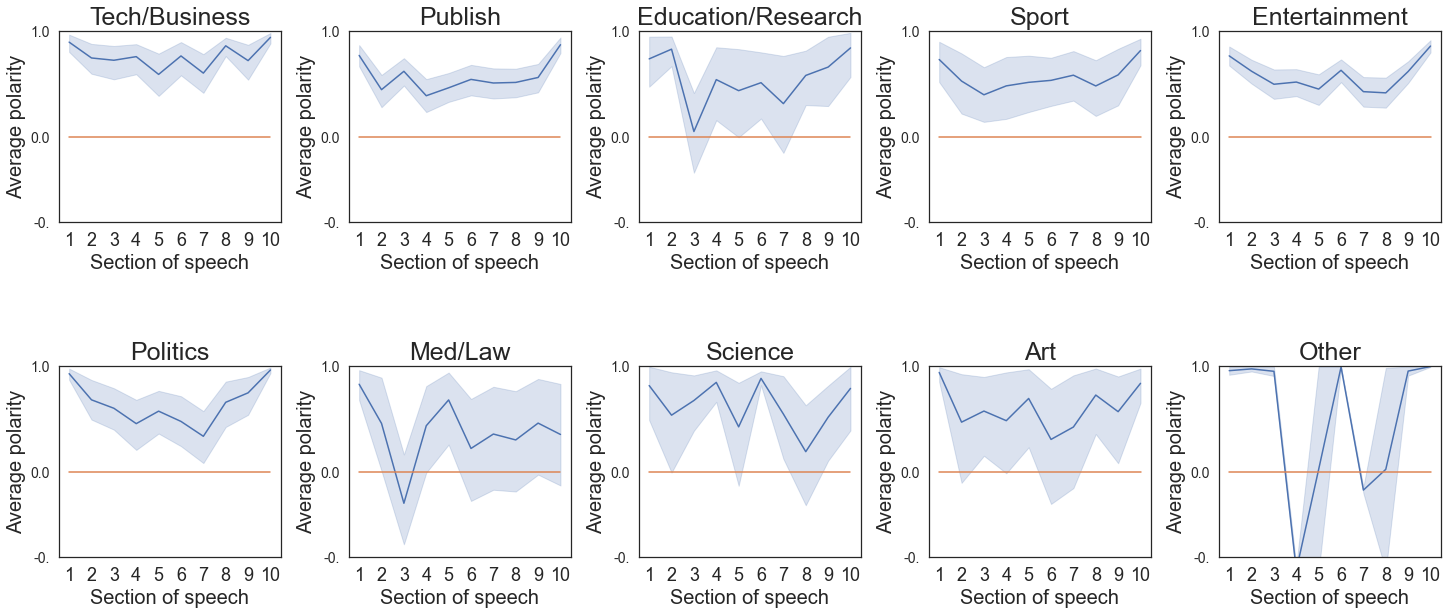

In [10]:
# Check all professions

plt.rcParams['figure.figsize'] = [20, 8]
sns.set_style("white")

num_plot = 10
categories = speech_concise.category.unique()

figure, axes = plt.subplots(num_plot//5,5)
figure.tight_layout(h_pad=10.0,w_pad=3.0)

for i in range(num_plot):    
    sub_df = speech_concise[speech_concise.category == categories[i]]
    
    plt.subplot(num_plot//5,5,i+1)
    polarity_all(sub_df,10)
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(categories[i], fontdict = {'fontsize' : 25})
    
plt.show()

In [11]:
# Some interesting findings: Tech/Business and Entertainment speakers are overall positive
# Med/Las and Education/Research speakers are less positive, even negative

## 3. Individual plot for selected profession

In [12]:
# function that return the melt df
def polarity_melt(df,num_split):
    # Split and analyze all transcripts
    all_transcripts = []

    for i in range(df.shape[0]):
        transcript = df.transcript.iloc[i]
        sents = split_text(transcript, n=num_split)
        results = []
        for sent in sents:
            ana = analyzer.polarity_scores(sent)
        #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
            results.append(ana['compound'])
        all_transcripts.append(results)

    # Create df
    vader_sent_df = pd.DataFrame(all_transcripts,
                                 columns=[str(i+1) for i in range(num_split)]                            )
    vader_sent_df['Transcript'] = [i for i in range(df.shape[0])]

    # Melt df (for sns lineplot 95% confidence interval)
    vader_sent_melt = pd.melt(vader_sent_df, id_vars='Transcript', value_vars = [str(i+1) for i in range(num_split)],
    #                          val_name = [str(i+1) for i in range(10)]
                             )

    return (vader_sent_melt)

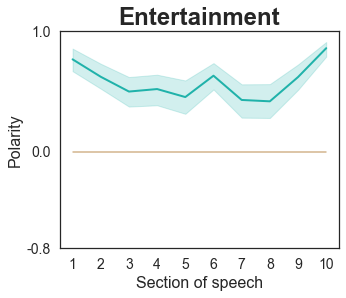

In [13]:
# Entertainment
sub_df = speech_concise[speech_concise.category == "Entertainment"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='lightseagreen',linewidth=2
             )
plt.title('Entertainment',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_entertain.pdf', bbox_inches='tight', transparent = True);

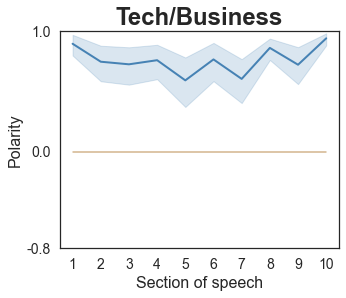

In [14]:
# Tech/business people
# Entertainment
sub_df = speech_concise[speech_concise.category == "Tech/Business"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='steelblue',linewidth=2
             )
plt.title('Tech/Business',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_tech.pdf', bbox_inches='tight', transparent = True);

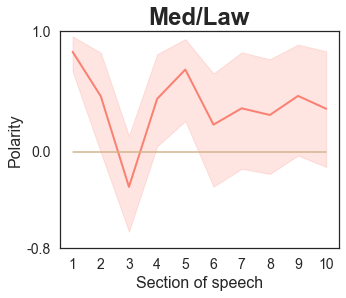

In [15]:
# Med/Law people
sub_df = speech_concise[speech_concise.category == "Med/Law"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='salmon',linewidth=2
             )
plt.title('Med/Law',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_med.pdf', bbox_inches='tight', transparent = True);

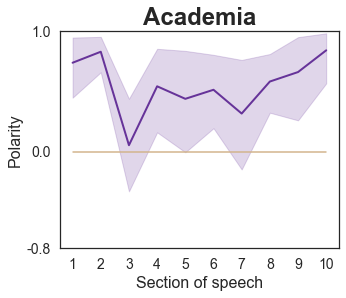

In [16]:
# Academia people
sub_df = speech_concise[speech_concise.category == "Education/Research"]
vader_sent_melt = polarity_melt(sub_df,10)

import matplotlib as mpl

fig,ax = plt.subplots(figsize=(5,4))
sns.set_style("white")
sns.lineplot(data=vader_sent_melt, x="variable", y="value",
             color='rebeccapurple',linewidth=2
             )
plt.title('Academia',fontsize=24,fontweight='bold')
plt.ylabel('Polarity',fontsize=16)
plt.xlabel('Section of speech',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.plot(np.arange(0,10), np.zeros(10),color='tan')
plt.ylim(-.75, 1)
plt.yticks([-0.8, 0 ,1], labels = ['-0.8', '0.0' ,'1.0'], fontsize=14)

fig.savefig('../plot/sent_academia.pdf', bbox_inches='tight', transparent = True);

### Smooth the line

Interpolate the data for smoother line, but does not look nice either. Will stick to the original plots.

In [17]:
# Smooth the line
from scipy.interpolate import interp1d

# Example
# # Original
# x = np.linspace(1, 15, num=16, endpoint=True)
# y = vader_sent_df.iloc[0].values

# # Interpolation
# f = interp1d(x, y)
# f2 = interp1d(x, y, kind='cubic')

# # Plot
# xnew = np.linspace(1, 15, num=100, endpoint=True)
# plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
# plt.legend(['data', 'linear', 'cubic'], loc='best')
# plt.show()

In [18]:
num_interp = 100
num_split = 10

def smooth_polarity(df, num_split, num_interp):
    
    all_transcripts = []

    for i in range(df.shape[0]):
        transcript = df.transcript.iloc[i]
        sents = split_text(transcript, n=num_split)
        results = []
        for sent in sents:
            ana = analyzer.polarity_scores(sent)
        #     results.append([ana['neg'],ana['neu'],ana['pos'],ana['compound']])
            results.append(ana['compound'])
        all_transcripts.append(results)

    # Create df
    vader_sent_df = pd.DataFrame(all_transcripts,
                                 columns=[str(i+1) for i in range(num_split)]                            )
    vader_sent_df['Transcript'] = [i for i in range(df.shape[0])]
    
    
    x = np.linspace(1, num_split, num=num_split, endpoint=True)
    xnew = np.linspace(1, num_split, num=num_interp, endpoint=True)

    y_new_list = []
    for i in range(vader_sent_df.shape[0]):    
        y = vader_sent_df.iloc[i,:-1].values

        # Interpolation
        f2 = interp1d(x, y, kind='cubic')
        y_new_list.append(f2(xnew))


    # Create df
    vader_sent_df_interp = pd.DataFrame(y_new_list,columns=[str(i+1) for i in range(num_interp)])
    vader_sent_df_interp['Transcript'] = [i for i in range(441)]


    # Melt df (for sns lineplot 95% confidence interval)
    vader_sent_interp_melt = pd.melt(vader_sent_df_interp, id_vars='Transcript',\
                                     value_vars = [str(i+1) for i in range(num_interp)],
    #                          val_name = [str(i+1) for i in range(10)]
                             )

    # sns lineplot
    # plt.rcParams['figure.figsize'] = [12, 8]
    fig,ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=vader_sent_interp_melt, x="variable", y="value")
    
    ax.grid(False)
    ax.axes.xaxis.set_ticks([])
    ax.set_title('Average polarity of all speeches over the duration',fontsize=20)
    ax.set_ylabel('Average polarity',fontsize=20)
    ax.set_xlabel('Throughout the speech',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14);

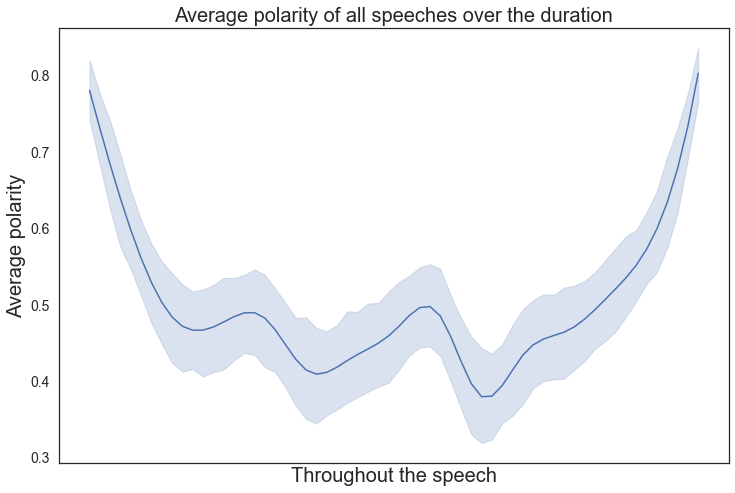

In [19]:
smooth_polarity(speech_df_raw, num_split=15, num_interp=60)